In [1]:
import sklearn.preprocessing
import sklearn.ensemble
import pandas as pd
import numpy as np
import os
import sklearn.model_selection
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn.manifold
import model
import sklearn.linear_model
import sklearn.svm
import scipy.stats
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.utils.data
import torchvision
import torchvision.transforms
import data_loader
import test
import model
%load_ext autoreload
%autoreload 2

### Prepare Dataset

In [2]:
source_dataset_name = 'MNIST'
target_dataset_name = 'mnist_m'
source_image_root = os.path.join('dataset', source_dataset_name)
target_image_root = os.path.join('dataset', target_dataset_name)
model_root = 'models'
cuda = True
cudnn.benchmark = True
image_size=28

manual_seed = 234
np.random.seed(manual_seed)
torch.manual_seed(manual_seed)

In [3]:
img_transform_source = torchvision.transforms.Compose([
    torchvision.transforms.Resize(image_size),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

img_transform_target = torchvision.transforms.Compose([
    torchvision.transforms.Resize(image_size),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

In [4]:
dataset_source = torchvision.datasets.MNIST(
    root='dataset',
    train=True,
    transform=img_transform_source,
    download=True
)
train_list = os.path.join(target_image_root, 'mnist_m_train_labels.txt')
dataset_target = data_loader.GetLoader(
    data_root=os.path.join(target_image_root, 'mnist_m_train'),
    data_list=train_list,
    transform=img_transform_target
)

In [5]:
def get_numpy_dataset(torch_dataset):
    X_list=[]
    Y_list=[]
    for i in range(len(torch_dataset)):
        X,Y=torch_dataset[i]
        if X.shape[0]==1:
            X=X.expand(3,-1,-1)
        elif X.shape[0]==3:
            pass
        else:
            assert False
        X_list.append(X)
        Y_list.append(Y)
    Y_arr=np.array(Y_list)
    X_arr=torch.stack(X_list,dim=0).numpy()
    return X_arr,Y_arr

In [6]:
X_source,Y_source=get_numpy_dataset(dataset_source)

In [7]:
X_target,Y_target=get_numpy_dataset(dataset_target)

### Prepare Models

In [21]:
class TrainableModel(nn.Module):
    def __init__(self,params):
        super().__init__()
        self.params=params
        self.loss_fn=params["loss_fn"]
        self.optimizer=None
    def fit(self,X,Y,test_data):
        params=self.params
        self.optimizer=torch.optim.Adam(self.parameters(),lr=params['lr'])
        self.train()
        X_tensor=torch.from_numpy(X)
        Y_tensor=torch.from_numpy(Y)
        
        train_dataset=torch.utils.data.TensorDataset(X_tensor,Y_tensor)
        train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=params["batch_size"])
        device=next(iter(self.parameters())).device
        for epoch in range(1,params["n_epochs"]+1):
            print("Begin Epoch %d"%(epoch))
            for i,(X_batch,Y_batch) in enumerate(train_loader):
                X_batch=X_batch.to(device)
                Y_batch=Y_batch.to(device)
                pred=self(X_batch)
                loss=self.loss_fn(pred,Y_batch)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                if i%100==0:
                    print("step [%d/%d], loss=%.4f"%(i+1,len(train_loader),loss))
            print("End of epoch evaluation:")
            print(self.score(*test_data))
    def score(self,X,Y):
        self.eval()
        X_tensor=torch.from_numpy(X)
        Y_tensor=torch.from_numpy(Y)
        
        test_dataset=torch.utils.data.TensorDataset(X_tensor,Y_tensor)
        test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=params["batch_size"])
        
        pred_list=list()
        device=next(iter(self.parameters())).device
        with torch.no_grad():
            for i,(X_batch,Y_batch) in enumerate(test_loader):
                X_batch=X_batch.to(device)
                Y_batch=Y_batch.to(device)
                pred=self(X_batch)
                pred=pred.argmax(dim=1)
                pred_list.append(pred)
        predictions_tensor=torch.cat(pred_list)
        predictions_arr=predictions_tensor.cpu().numpy()
        score=dict()
        score["accuracy"]=np.mean(predictions_arr==Y)
        return score
            
class FeatureAndClassifierModel(TrainableModel):
    def __init__(self,params):
        super().__init__(params)
        self.feature = nn.Sequential()
        self.feature.add_module('f_conv1', nn.Conv2d(3, 64, kernel_size=5))
        self.feature.add_module('f_bn1', nn.BatchNorm2d(64))
        self.feature.add_module('f_pool1', nn.MaxPool2d(2))
        self.feature.add_module('f_relu1', nn.ReLU(True))
        self.feature.add_module('f_conv2', nn.Conv2d(64, 50, kernel_size=5))
        self.feature.add_module('f_bn2', nn.BatchNorm2d(50))
        self.feature.add_module('f_drop1', nn.Dropout2d())
        self.feature.add_module('f_pool2', nn.MaxPool2d(2))
        self.feature.add_module('f_relu2', nn.ReLU(True))
        
        mock_input=torch.rand(2,3,28,28)
        mock_output=self.feature(mock_input)
        self.feature_size=np.prod(mock_output.shape[1:])
        print(self.feature_size)
        
        self.class_classifier = nn.Sequential()
        self.class_classifier.add_module('c_fc1', nn.Linear(self.feature_size, 100))
        self.class_classifier.add_module('c_bn1', nn.BatchNorm1d(100))
        self.class_classifier.add_module('c_relu1', nn.ReLU(True))
        self.class_classifier.add_module('c_drop1', nn.Dropout())
        self.class_classifier.add_module('c_fc2', nn.Linear(100, 100))
        self.class_classifier.add_module('c_bn2', nn.BatchNorm1d(100))
        self.class_classifier.add_module('c_relu2', nn.ReLU(True))
        self.class_classifier.add_module('c_fc3', nn.Linear(100, 10))
        self.class_classifier.add_module('c_softmax', nn.LogSoftmax(dim=1))
    def forward(self,X):
        X=self.feature(X)
        X=X.view(-1,self.feature_size)
        X=self.class_classifier(X)
        return X

class ClassifierModel(TrainableModel):
    def __init__(self,params):
        super().__init__(params)
        self.feature_size=800
        self.class_classifier = nn.Sequential()
        self.class_classifier.add_module('c_fc1', nn.Linear(self.feature_size, 100))
        self.class_classifier.add_module('c_bn1', nn.BatchNorm1d(100))
        self.class_classifier.add_module('c_relu1', nn.ReLU(True))
        self.class_classifier.add_module('c_drop1', nn.Dropout())
        self.class_classifier.add_module('c_fc2', nn.Linear(100, 100))
        self.class_classifier.add_module('c_bn2', nn.BatchNorm1d(100))
        self.class_classifier.add_module('c_relu2', nn.ReLU(True))
        self.class_classifier.add_module('c_fc3', nn.Linear(100, 10))
        self.class_classifier.add_module('c_softmax', nn.LogSoftmax(dim=1))
    def forward(self,X):
        X=self.class_classifier(X)
        return X

### Test on Un-transformed data

In [19]:
params={
    'lr' : 1e-3,
    'batch_size' : 128,
    'device':'cuda:0' if torch.cuda.is_available() else 'cpu',
    'n_epochs':10,
    'loss_fn':torch.nn.NLLLoss()
}
model=FeatureAndClassifierModel(params)
model=model.to(params["device"])

datester=DomainAdaptationTester(X_source,Y_source,X_target,Y_target)
print(datester.test_on_source(model))

model=FeatureAndClassifierModel(params)
model=model.to(params["device"])
print(datester.test_on_target(model))

800
Begin Epoch 1
step [1/375], loss=2.3809
step [101/375], loss=0.3434
step [201/375], loss=0.2061
step [301/375], loss=0.1261
End of epoch evaluation:
{'accuracy': 0.9809166666666667}
Begin Epoch 2
step [1/375], loss=0.0176
step [101/375], loss=0.0214
step [201/375], loss=0.0195
step [301/375], loss=0.0274
End of epoch evaluation:
{'accuracy': 0.9870833333333333}
Begin Epoch 3
step [1/375], loss=0.0066
step [101/375], loss=0.0207
step [201/375], loss=0.0149
step [301/375], loss=0.0241
End of epoch evaluation:
{'accuracy': 0.9879166666666667}
Begin Epoch 4
step [1/375], loss=0.0058
step [101/375], loss=0.0048
step [201/375], loss=0.0080
step [301/375], loss=0.0060
End of epoch evaluation:
{'accuracy': 0.9865}
Begin Epoch 5
step [1/375], loss=0.0052
step [101/375], loss=0.0072
step [201/375], loss=0.0030
step [301/375], loss=0.0269
End of epoch evaluation:
{'accuracy': 0.987}
Begin Epoch 6
step [1/375], loss=0.0025
step [101/375], loss=0.0113
step [201/375], loss=0.0008
step [301/375],

### Test on transformed data

In [67]:
def model_transform(X,batch_size=128):
    model_fp="/data/liz0f/DANN_py3/models/mnist_mnistm_model_epoch_best.pth"
    cnnmodel=torch.load(model_fp)
    device=next(cnnmodel.parameters()).device
    X_tensor=torch.from_numpy(X)
    
    dataset=torch.utils.data.TensorDataset(X_tensor)
    loader=torch.utils.data.DataLoader(dataset,batch_size=batch_size)
    cnnmodel.eval()
    X_transformed_tensor_list=list()
    def fc_transformation(fc,val):
        module_list=list(fc._modules.values())[:6]
        for m in module_list:
            val=m(val)
        return val
    with torch.no_grad():
        for i,(X_batch,) in enumerate(loader):
            X_batch=X_batch.to(device)
            X_batch_transformed_tensor=cnnmodel.feature(X_batch)
            X_batch_transformed_tensor=X_batch_transformed_tensor.view(X_batch.shape[0],-1)
            X_batch_transformed_tensor=fc_transformation(cnnmodel.class_classifier,X_batch_transformed_tensor)
            X_transformed_tensor_list.append(X_batch_transformed_tensor)
        X_transformed_tensor=torch.cat(X_transformed_tensor_list,dim=0)
    X_transformed_arr=X_transformed_tensor.cpu().numpy()
    return X_transformed_arr

In [15]:
model_fp="/data/liz0f/DANN_py3/models/mnist_mnistm_model_epoch_best.pth"
cnnmodel_old=torch.load(model_fp)
cnnmodel=model.CNNModel()
cnnmodel.load_state_dict(cnnmodel_old.state_dict())

<All keys matched successfully>

In [16]:
X_source_transformed=cnnmodel.transform(X_source)
X_target_transformed=cnnmodel.transform(X_target)

In [22]:
params={
    'lr' : 1e-3,
    'batch_size' : 128,
    'device':'cuda:0' if torch.cuda.is_available() else 'cpu',
    'n_epochs':100,
    'loss_fn':torch.nn.NLLLoss()
}
model=ClassifierModel(params)
model=model.to(params["device"])

datester=test.DomainAdaptationTester(X_source_transformed,Y_source,X_target_transformed,Y_target)
print(datester.test_on_source(model))



Begin Epoch 1


RuntimeError: size mismatch, m1: [128 x 100], m2: [800 x 100] at /tmp/pip-req-build-58y_cjjl/aten/src/THC/generic/THCTensorMathBlas.cu:273

In [ ]:
model=ClassifierModel(params)
model=model.to(params["device"])
print(datester.test_on_target(model))

#### Random Forest

In [29]:
import sklearn.ensemble
rf=sklearn.ensemble.RandomForestClassifier(n_jobs=30)
print(datester.test_on_target(rf))

/home/liz0f/app/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.5727021575905493


### tSNE plot

In [49]:
X_source_flatten=X_source.reshape(X_source.shape[0],-1)
X_target_flatten=X_target.reshape(X_target.shape[0],-1)
datester_untransformed=test.DomainAdaptationTester(X_source_flatten,Y_source,X_target_flatten,Y_target)

[0 1 2 3 4 5 6 7 8 9]


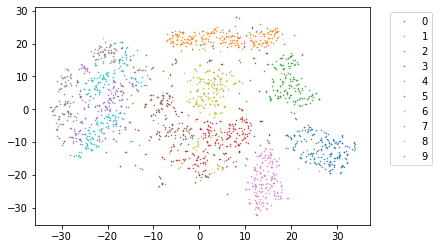

In [51]:
datester_untransformed.show_tsne_plot(set="source")

[0 1 2 3 4 5 6 7 8 9]


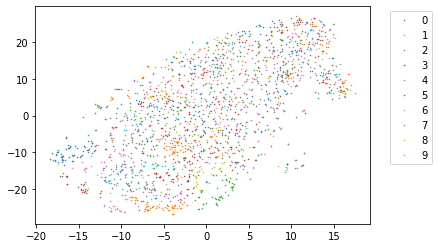

In [52]:
datester_untransformed.show_tsne_plot(set="target")

[0 1 2 3 4 5 6 7 8 9]
[1 2]


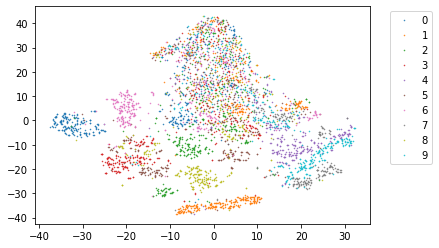

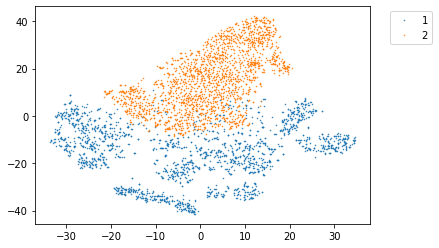

In [53]:
datester_untransformed.show_tsne_plot(set="all")

In [23]:
datester_transformed=test.DomainAdaptationTester(X_source_transformed,Y_source,X_target_transformed,Y_target)

[0 1 2 3 4 5 6 7 8 9]


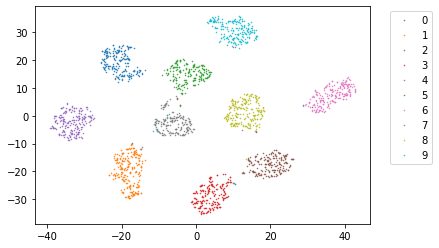

In [24]:
datester_transformed.show_tsne_plot(set="source")

[0 1 2 3 4 5 6 7 8 9]


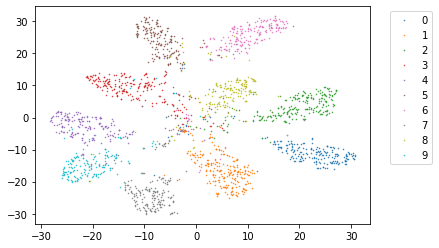

In [25]:
datester_transformed.show_tsne_plot(set="target")

[0 1 2 3 4 5 6 7 8 9]
[1 2]


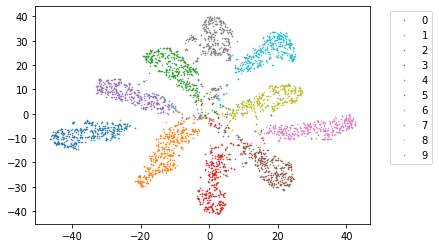

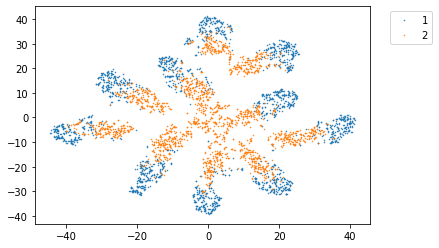

In [26]:
datester_transformed.show_tsne_plot(set="all")

In [62]:
model_fp="/data/liz0f/DANN_py3/models/mnist_mnistm_model_epoch_best.pth"
cnnmodel=torch.load(model_fp)
test.score(cnnmodel,X_source,Y_source)

{'accuracy': 0.9899333333333333}

In [66]:
cnnmodel.class_classifier._modules

OrderedDict([('c_fc1', Linear(in_features=800, out_features=100, bias=True)),
             ('c_bn1',
              BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
             ('c_relu1', ReLU(inplace=True)),
             ('c_drop1', Dropout(p=0.5, inplace=False)),
             ('c_fc2', Linear(in_features=100, out_features=100, bias=True)),
             ('c_bn2',
              BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
             ('c_relu2', ReLU(inplace=True)),
             ('c_fc3', Linear(in_features=100, out_features=10, bias=True)),
             ('c_softmax', LogSoftmax())])